# DiffForms

Train a neural network $f: \mathbb{R}^D \rightarrow \mathbb{R}$ that outputs values over a point cloud in such a way that the function varies smoothly over the manifold formed by the data

**Summary:**

1. Here we create an arbitrary point cloud:  

   $ X \in \mathbb{R}^{N \times D} $

2. Then Build a **k-NN graph** (k=6) with Euclidean distances

3. Next, we compute the **heat kernel matrix**  

   $
   K_t(i,j) = \frac{1}{(4\pi t)^{d/2}} \exp\left( -\frac{\|x_i - x_j\|^2}{4t} \right)
   $

4. We create a **discrete Laplacian** from the kernel (normalised or unnormalised -- To be implemented!)

5. Train a model - simple MLP - to **approximate a function** that minimises a Laplacian regularisation:  

   $
   \mathcal{L}(f) = f^\top L f = \sum_{i,j} K_t(i,j) (f_i - f_j)^2
   $


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_swiss_roll
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [12]:
# Parameters
N = 10_000         # number of points
D = 3           # dimension of each point
k = 6           # k-NN
t = 1.0         # heat kernel time

# Step 1: Create random point cloud
#X = torch.randn(N, D)

# Create Swiss Rolls
X_np, _ = make_swiss_roll(n_samples=N, noise=0.1)
X = torch.tensor(X_np, dtype=torch.float32)

# Step 2: k-NN graph
nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X)  # +1 includes the point itself
distances, indices = nbrs.kneighbors(X)

# Step 3: Build heat kernel matrix
heat_kernel = torch.zeros(N, N)

for i in range(N):
    """
    How heat would diffuse from poin i to point j over time t. 
    This favours local interactions, and is closely related to the Gaussian kernel. 
    The kernel is symmetric and positive, giving rise to a weighted adjacency matrix for the graph.
    """
    for j_idx, j in enumerate(indices[i][1:]):  # Skip self-loop
        d2 = torch.norm(X[i] - X[j]) ** 2
        coef = 1 / ((4 * np.pi * t) ** (D / 2))
        heat_kernel[i, j] = coef * torch.exp(-d2 / (4 * t))
        heat_kernel[j, i] = heat_kernel[i, j]  # symmetry


In [13]:
# Degree matrix
deg = torch.diag(heat_kernel.sum(dim=1))

# Unnormalised Laplacian
L = deg - heat_kernel

# Normalised Laplacian
# L = IDENTITY − deg^{-1/2} @ K @ D^{−1/2}

By optimising the Laplacian loss, the model learns a function that respects the geometry of the data. 

This is useful in many contexts and connects ideas from spectral graph theory, differential geometry, and machine learning.

In [14]:
class DiffForms(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
model = DiffForms(D, 32, 1)  # scalar-valued function on point cloud
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Laplacian smoothing loss
def laplacian_loss(f_vals, L):
    """
    This is the Dirichlet energy of f
    It encourages neighbouring points with strong kernel affinity to have similar function values. 
    Minimising this loss promotes smoothness of f over the manifold.
    """
    return torch.sum(f_vals.T @ L @ f_vals)

losses = []
predictions = [] 
# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    f_vals = model(X) # f : R^D -> R
    loss = laplacian_loss(f_vals, L)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Laplacian loss = {loss.item():.6f}")
        losses.append(loss.item())
        predictions.append(f_vals.detach().numpy())


Epoch 0: Laplacian loss = 7.260618
Epoch 5: Laplacian loss = 0.652879
Epoch 10: Laplacian loss = 0.865948
Epoch 15: Laplacian loss = 0.474967
Epoch 20: Laplacian loss = 0.172570
Epoch 25: Laplacian loss = 0.158392
Epoch 30: Laplacian loss = 0.129781
Epoch 35: Laplacian loss = 0.091510
Epoch 40: Laplacian loss = 0.064685
Epoch 45: Laplacian loss = 0.049210
Epoch 50: Laplacian loss = 0.039946
Epoch 55: Laplacian loss = 0.031871
Epoch 60: Laplacian loss = 0.025127
Epoch 65: Laplacian loss = 0.021045
Epoch 70: Laplacian loss = 0.017875
Epoch 75: Laplacian loss = 0.015513
Epoch 80: Laplacian loss = 0.013301
Epoch 85: Laplacian loss = 0.011862
Epoch 90: Laplacian loss = 0.010648
Epoch 95: Laplacian loss = 0.009550
Epoch 100: Laplacian loss = 0.008622
Epoch 105: Laplacian loss = 0.007907
Epoch 110: Laplacian loss = 0.007251
Epoch 115: Laplacian loss = 0.006688
Epoch 120: Laplacian loss = 0.006149
Epoch 125: Laplacian loss = 0.005650
Epoch 130: Laplacian loss = 0.005202
Epoch 135: Laplacian lo

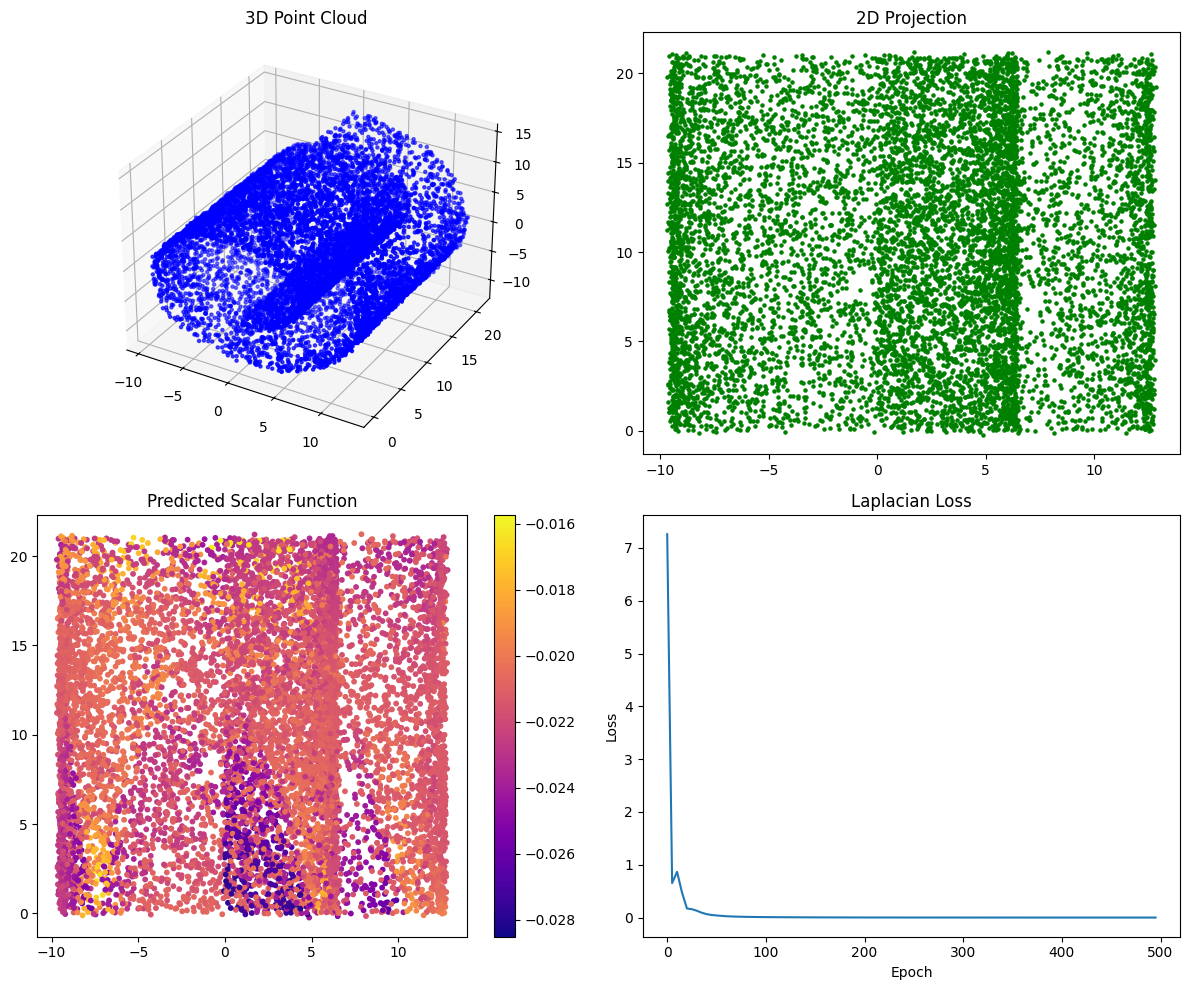

In [15]:
# Visualisation
fig = plt.figure(figsize=(12, 10))

# Original point cloud (3D)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c='blue', s=5)
ax1.set_title("3D Point Cloud")

# 2D projection (first two dims)
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(X_np[:, 0], X_np[:, 1], c='green', s=5)
ax2.set_title("2D Projection")

# Final predictions
ax3 = fig.add_subplot(2, 2, 3)
sc = ax3.scatter(X_np[:, 0], X_np[:, 1], c=predictions[-1].squeeze(), cmap='plasma', s=10)
fig.colorbar(sc, ax=ax3)
ax3.set_title("Predicted Scalar Function")

# Loss over epochs
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(range(0, 500, 5), losses)
ax4.set_title("Laplacian Loss")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Loss")

fig.tight_layout()
plt.show()


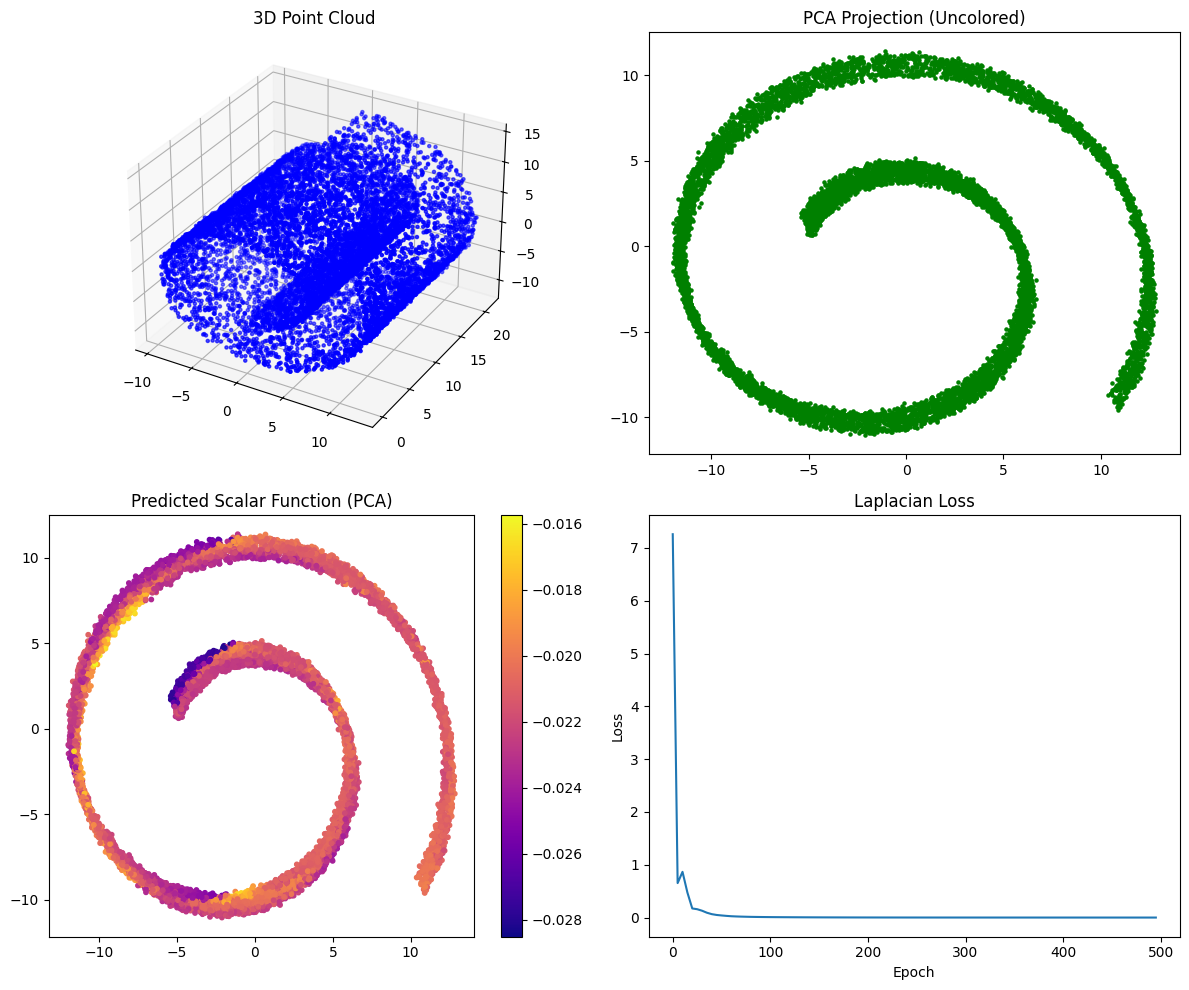

In [17]:
from sklearn.decomposition import PCA

# Reduce dimensionality for better visualisation of scalar predictions
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_np)

# Enhanced visualisation with prediction on projected space
fig = plt.figure(figsize=(12, 10))

# Original 3D point cloud
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c='blue', s=5)
ax1.set_title("3D Point Cloud")

# PCA projection
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(X_2d[:, 0], X_2d[:, 1], c='green', s=5)
ax2.set_title("PCA Projection (Uncolored)")

# PCA with predictions
ax3 = fig.add_subplot(2, 2, 3)
sc = ax3.scatter(X_2d[:, 0], X_2d[:, 1], c=predictions[-1].squeeze(), cmap='plasma', s=10)
fig.colorbar(sc, ax=ax3)
ax3.set_title("Predicted Scalar Function (PCA)")

# Loss over training
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(range(0, 500, 5), losses)
ax4.set_title("Laplacian Loss")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Loss")

fig.tight_layout()
plt.show()
